In [1]:
# run first rlp_statistics_prepare to set land use parameters (sealing, tree cover), regions (hydrogeological, fokus)

region = 'RLP_total'

radius_selected = 100 # for sealing (m)
T_selected = 50  # depth (m)

sealing_selected = f'sealing_{radius_selected}'
#para_list = [f'T_{T_selected}', 'elevation', sealing_selected]

# explanatory variables in regression analysis
cols = ["elevation", 
        sealing_selected,
        #'tree_cover_100',
        #'elevation_sq'
       ]

use_log = False # True   # logarithmic temperature (response variable) in regression analysis


regions_hg = [
    'rhine_graben_slab',
    'rhine_graben_zwischenscholle',
    'mainz_basin_tertiary',
    'quaternary_north_west',
    'quaternary_middle_rhine',
    'tertiary_quaternary_rhine_main',
    'palatinate_buntsandstein',
    'palatinate_muschelkalk',
    'triassic_north_west',
    'tertiary_north_west',    
    'palatinate_permokarbon',
    'perm_nahe_prims_basin',
    'palatinate_slate_mountain_range_south',
    'palatinate_slate_mountain_range_north',
    'lahn_dill',
    'westerwald_tertiary',
    'limestone_depression_buntsandstein_vulkanite',
    'kaenozoic_vulkanite'   
]

regions_main_colors = ["#1f77b4",
                       "#8c564b",
                       "#2ca02c",
                       "#ff7f0e",
                       "#9467bd",
                       "#d62728",  
                       "#1a1a1a", # "#7f7f7f"
                       "#e377c2",
                       "#9467bd"
                      ]

regions_hg_path = '/home/jens/daten/geometries/geological_regions/RLP/hydrogeology'

<h1> Import </h1>

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from geoalchemy2 import Geometry

from scipy.spatial import cKDTree
from scipy.ndimage import sobel
from scipy.stats import linregress, ks_2samp, wasserstein_distance

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

import rioxarray
import xarray as xr

import rasterio
from rasterio.transform import rowcol
from rasterio.enums import Resampling
from rasterio.warp import transform, reproject, calculate_default_transform, Resampling
from rasterio.mask import mask
from rasterstats import zonal_stats
from rasterio.shutil import copy as rio_copy
from rasterio.crs import CRS

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from math import pi
import pprint
from tabulate import tabulate



plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
}
)

In [3]:
df = pd.read_csv('df4statstools.csv') # take output from rlp_statistics_prepare


user, password ='postgres', 'postgres'
schema, host = 'DB_RLP_temperature_shallow', '127.0.0.1'
connection_string='postgresql://{}:{}@{}:5432/{}'.format(user, password, host, schema)

engine = create_engine(connection_string)

df_fit = pd.read_sql_query("SELECT * FROM fitting;", engine)
df_bh = pd.read_sql_query("SELECT * FROM borehole_evaluation;", engine)

#regions = df['region_hg'].unique().tolist()
#df.head()

<h1> Functions </h1>

In [4]:
scaler = StandardScaler()

def calculate_original(_model, _df, _cols, use_log, scaler):
    _means = _df[_cols].mean()
    _stds = _df[_cols].std()

    _betas_std = _model.params#[cols]
    _betas_orig = _betas_std / _stds

    _std_err_std = _model.bse
    _std_err_orig = _std_err_std / _stds

    _#intercept_orig = _df[f"T_{T_selected}"].mean() - np.sum(_betas_orig * _means)
    #_intercept_orig = np.log(_df[f"T_{T_selected}"].mean()) - np.sum(_betas_orig * _means)
    if use_log:
        # scallierung ???
        _intercept_orig = _df[f"T_{T_selected}"].apply(np.log).mean() - np.sum(_betas_orig * _means)
    else:
        mean_X = scaler.mean_
        std_X = np.sqrt(scaler.var_)
        betas_scaled = _model.params.drop('const')

        _intercept_orig = _model.params['const'] - np.sum(betas_scaled * mean_X / std_X)

        #_intercept_orig = _model.params['const'] # _df[f"T_{T_selected}"].mean() - np.sum(_betas_orig * _means)
        
    #print(_betas_std, _std_err_std)
    return _betas_orig, _std_err_orig, _intercept_orig


def remove_outliers(_df, _factor, _parameter):


    _df_clean = _df.dropna(subset=[_parameter]) # updated below
    
    _q1, _q3 = np.percentile(_df_clean[_parameter].to_numpy(), [25, 75])
    _iqr = _q3 - _q1
    _lower_bound = _q1 - _factor * _iqr
    _upper_bound = _q3 + _factor * _iqr
    
    print(f'\tbounds: {_lower_bound:.1f} {_upper_bound:.1f}, parameter: {_parameter} {_factor}')
    # print('\t\tOrig: ', _df_clean.shape)
    
    _df_clean = _df_clean[(_df_clean[_parameter]>_lower_bound)&(_df_clean[_parameter]<_upper_bound) ]
    
    # print('\t\tCleaned ', _df_clean.shape)

    return _df_clean

In [5]:

def export_result(_df, _col):

    _user, _password ='postgres', 'postgres'
    _schema, _host = 'DB_RLP_temperature_shallow', '127.0.0.1'
    _connection_string='postgresql://{}:{}@{}:5432/{}'.format(_user, _password, _host, _schema)
    
    _engine = create_engine(_connection_string)
    
    _framename = f'{_col}_predict'
    
    _df['delta_'+ _col] =  _df[_col] - _df[_col+'_predict']

    _df[['borehole_id', _col+'_predict', 'delta_'+_col,'geometry', 'utm_easting', 'utm_northing']].to_sql(
        _framename, _engine, if_exists='replace', index=False,
                                                       dtype={'geometry': Geometry('POINT', srid=4326)})

In [6]:
def get_prediction(_df, _betas, _cols, _intercept, model, use_log):
    """Berechnet Vorhersagen, mit Rücktransformation bei log-Modell"""
    _df[f'T_{T_selected}_predict_log'] = _intercept
    for col in _cols:
        _df[f'T_{T_selected}_predict_log'] += _df[col] * _betas[col]

    if use_log:
        # Bias-Korrektur
        sigma2 = model.mse_resid
        _df[f'T_{T_selected}_predict'] = np.exp(_df[f'T_{T_selected}_predict_log'] + 0.5 * sigma2)
    else:
        _df[f'T_{T_selected}_predict'] = _df[f'T_{T_selected}_predict_log']
    
    return _df

def plot_pair(_df, ax):
 
    cmap = plt.get_cmap("plasma")
    
    g = sns.scatterplot(
        data=_df,
        x=f'T_{T_selected}', y=f'T_{T_selected}_predict',
        hue=sealing_selected, size="elevation",
        palette=cmap, sizes=(10, 200), ax=ax
    )

    ax.grid(True, "minor", linewidth=.25)
    ax.plot([7, 13], [7, 13])   

<h1> Data preparation </h1>

Neither deactivated, impacted by drilling nor deep wells from GeoTis: 339
And at depth T_50: 260
	bounds: 6.0 14.7, parameter: T_50 1.5
And outlier removed (factor 1.5): 250


<Axes: ylabel='T_50'>

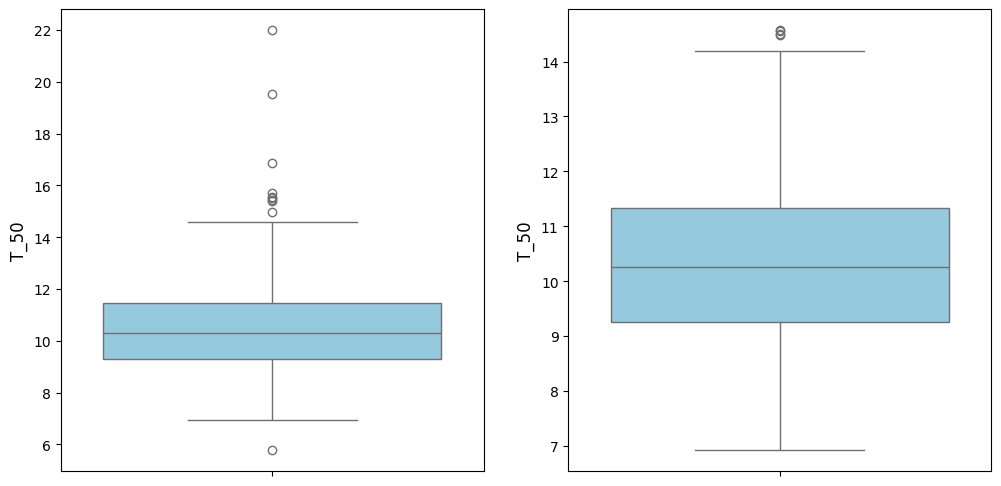

In [7]:
# filter

df_filter = df[~df['borehole_id'].astype(str).str.startswith('GT')]

df_filter = df_filter[df_filter['drillingInduced'] == False]
df_filter = df_filter[df_filter['deactivated'] == False]

print(f'Neither deactivated, impacted by drilling nor deep wells from GeoTis: {df_filter.shape[0]}')

df_filter = df_filter.dropna(subset=[f"T_{T_selected}"])
print(f'And at depth {f"T_{T_selected}"}: {df_filter.shape[0]}')

factor = 1.5
df_filter_clear = remove_outliers(df_filter, factor, f"T_{T_selected}")   # !!!!!


print(f'And outlier removed (factor {factor}): {df_filter_clear.shape[0]}')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y=df_filter[f"T_{T_selected}"], color='skyblue', ax=axes[0])
sns.boxplot(y=df_filter_clear[f"T_{T_selected}"], color='skyblue', ax=axes[1])



In [8]:
for region in regions_hg:
    shapefile = 'region_{}.shp'.format(region)
    
    polygon_gdf = gpd.read_file(regions_hg_path + '/' + shapefile)  # Pfad zum Shapefile anpassen
    polygon_gdf = polygon_gdf.to_crs(epsg=25832)  # In UTM-Zone 33N umprojizieren (Beispiel für Deutschland)
    
    geometry = [Point(xy) for xy in zip(df_filter["utm_easting"], df_filter["utm_northing"])]
    gdf = gpd.GeoDataFrame(df_filter, geometry=geometry, crs="EPSG:25832")  # Falls UTM-Zone 33N
    gdf_filtered = gdf[gdf.within(polygon_gdf.union_all())]
    #df_regions_main[region] = gdf_filtered.drop(columns="geometry")
    df_filter.loc[gdf_filtered.index, 'region_hg'] = region



df_filter.loc[df_filter['region_hg'].isin(['palatinate_buntsandstein', 'palatinate_muschelkalk']), 'region_main'] = 'palatinate_triassic'
df_filter.loc[df_filter['region_hg'].isin(['quaternary_middle_rhine']), 'region_main'] = 'middle_rhein'
df_filter.loc[df_filter['region_hg'].isin(['mainz_basin_tertiary', 'tertiary_quaternary_rhine_main']), 'region_main'] = 'mainz_basin'
df_filter.loc[df_filter['region_hg'].isin(['palatinate_permokarbon', 'perm_nahe_prims_basin']), 'region_main'] = 'saar_nahe'
df_filter.loc[df_filter['region_hg'].isin(['palatinate_slate_mountain_range_south', 'palatinate_slate_mountain_range_north',
                            'limestone_depression_buntsandstein_vulkanite', 
                             'quaternary_north_west', 'tertiary_north_west', 'triassic_north_west',
                            'lahn_dill']), 'region_main'] = 'palatinate_slate'
df_filter.loc[df_filter['region_hg'].isin(['westerwald_tertiary']), 'region_main'] = 'westerwald'
df_filter.loc[df_filter['region_hg'].isin(['kaenozoic_vulkanite']), 'region_main'] = 'lake_laach'
df_filter.loc[df_filter['region_hg'].isin(['rhine_graben_slab', 'rhine_graben_zwischenscholle']), 'region_main'] = 'upper_rhine_graben'

#regions_main = df_filter['region_main'].unique().tolist()
regions_main = ['westerwald', 'lake_laach', 'palatinate_slate', 'palatinate_triassic', 
                'saar_nahe', 'mainz_basin', 'upper_rhine_graben', 'middle_rhein']

<h1> Fitting </h1>

betas orig
const               NaN
elevation     -0.008789
sealing_100    0.012684
dtype: float64 const               NaN
elevation      0.000680
sealing_100    0.004026
dtype: float64 12.662277853596251
---
                            OLS Regression Results                            
Dep. Variable:                   T_50   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     102.1
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           4.72e-33
Time:                        22:14:58   Log-Likelihood:                -390.55
No. Observations:                 250   AIC:                             787.1
Df Residuals:                     247   BIC:                             797.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
  

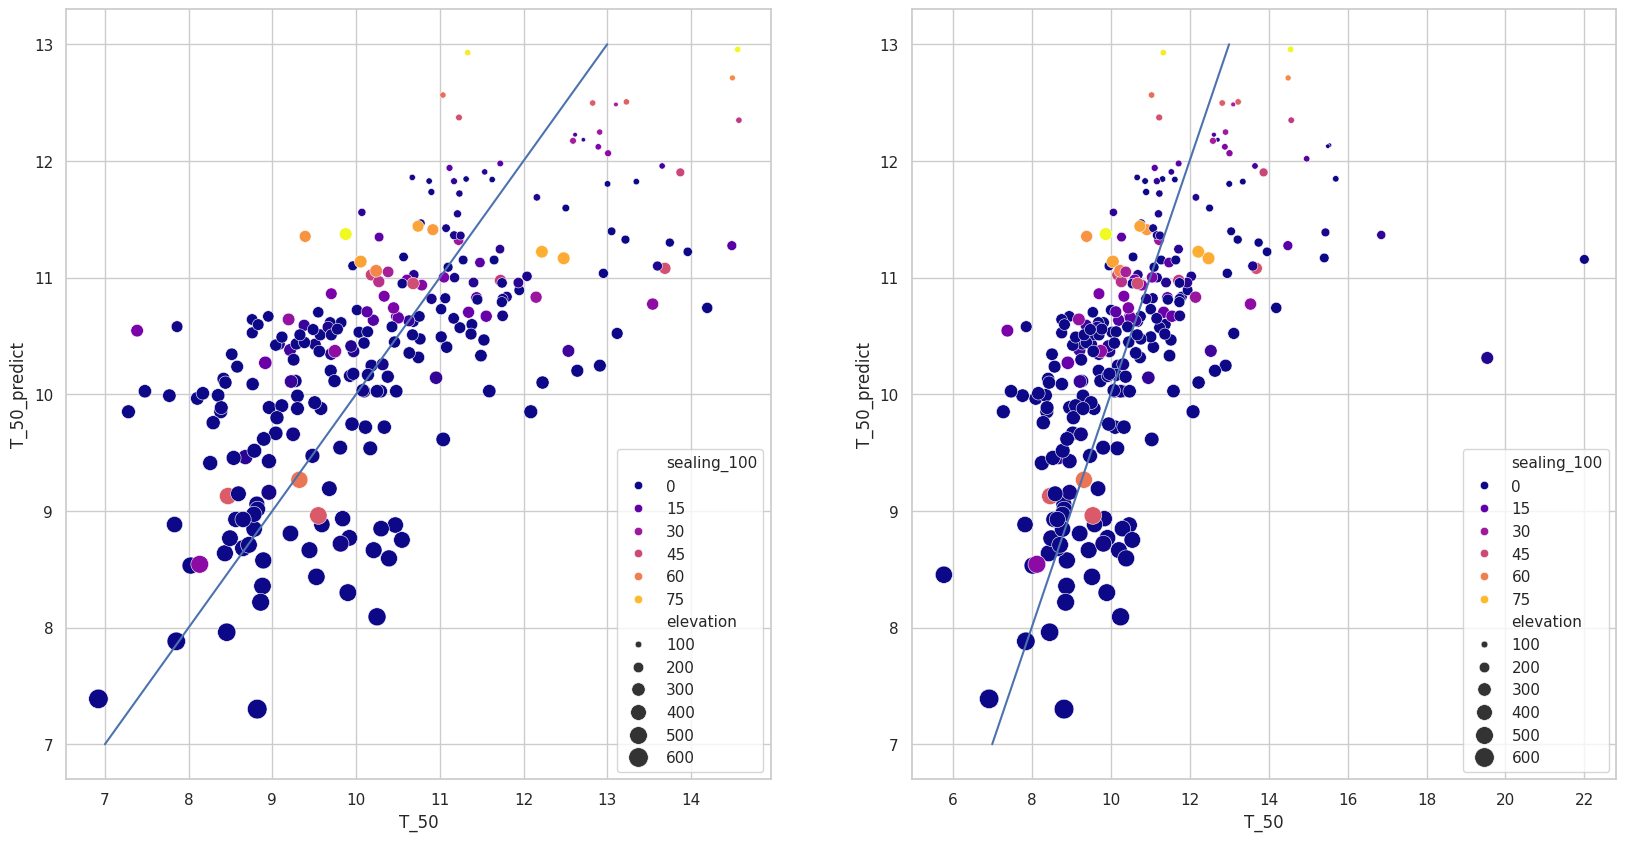

In [9]:

df_filter['elevation_sq'] = df_filter['elevation'] ** 2
df_filter_clear['elevation_sq'] = df_filter_clear['elevation'] ** 2

#####

y = df_filter_clear[f"T_{T_selected}"]

#print(df_model[cols])
X = sm.add_constant(pd.DataFrame(scaler.fit_transform(df_filter_clear[cols]), 
                                 columns=cols, index=df_filter_clear.index))
#print(X)
if use_log:
    model = sm.OLS(np.log(y), X).fit()
else:
    model = sm.OLS(y, X).fit()
    
betas_orig, std_err_orig, intercept_orig = calculate_original(model, df_filter_clear, cols, use_log, scaler)
print("betas orig")
print(betas_orig, std_err_orig, intercept_orig)
print("---")
print(model.summary())

# --- NEU: Rücktransformierte Vorhersagen ---
df_filter_clear_result = get_prediction(df_filter_clear, betas_orig, cols, intercept_orig, model, use_log)
df_filter_result = get_prediction(df_filter, betas_orig, cols, intercept_orig, model, use_log)

# --- Optional: Kontrolle ---
print(df_filter_result[[f"T_{T_selected}", f"T_{T_selected}_predict"]].head())

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_pair(df_filter_clear_result, ax=axes[0])
plot_pair(df_filter_result, ax=axes[1])

export_result(df_filter_result, f'T_{T_selected}')


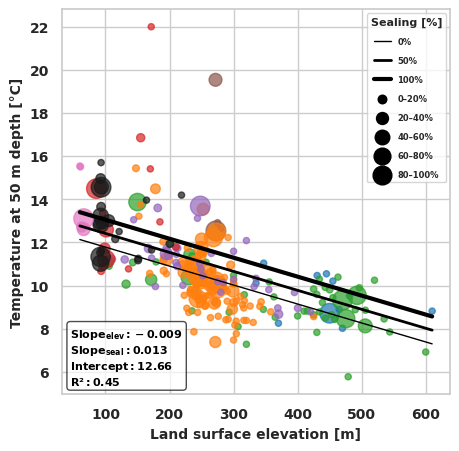

In [11]:
# Wertebereich für Elevation
elev_range = np.linspace(df_filter['elevation'].min(), df_filter['elevation'].max(), 100)

# Regressionsgeraden für feste Sealing-Werte
sealing_values_lines = [0, 50, 100]
linewidths = [1, 2, 3]

plt.figure(figsize=(5,5))

# Punktgröße prâoportional zu Sealing
s_min, s_max = 20, 200  # minimale und maximale Punktgröße


# Scatter-Punkte schwarz
#plt.scatter(df_filter['elevation'], df_filter['T_50'], c='black', s=sizes, alpha=0.7, edgecolor='k')#, label='Observed')
for ndx, region in enumerate(regions_main):
    df_filter_reg = df_filter[df_filter['region_main'] == region]
    sizes = s_min + (df_filter_reg[sealing_selected] / df_filter_reg[sealing_selected].max()) * (s_max - s_min)
    plt.scatter(df_filter_reg['elevation'], df_filter_reg['T_50'], color=regions_main_colors[ndx], 
                s=sizes, alpha=.7, 
                #edgecolor='k'
               #label='Observed'
               )

    #sns.scatterplot(x='elevation', y='T_50', data=df_filter_reg, color=regions_main_colors[ndx])


# Regressionsgeraden mit customized Labels
for seal, linewidth in zip(sealing_values_lines, linewidths):
    if use_log:
        if sealing_selected in cols:
            T_pred_line = np.exp(intercept_orig + betas_orig['elevation']*elev_range + betas_orig[sealing_selected]*seal)
        else:
            T_pred_line = np.exp(intercept_orig + betas_orig['elevation']*elev_range)
    else:
        if sealing_selected in cols:
            T_pred_line = intercept_orig + betas_orig['elevation']*elev_range + betas_orig[sealing_selected]*seal
        else:
            T_pred_line = intercept_orig + betas_orig['elevation']*elev_range       
    plt.plot(elev_range, T_pred_line, linewidth=linewidth, label=f'{seal}%', color='black')

# Dummy-Punkte für Legende der Größen in 20%-Schritten
# 0–20%, 20–40%, 40–60%, 60–80%, 80–100%
sealing_bins = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
for (low, high) in sealing_bins:
    mid_val = (low + high) / 2
    plt.scatter([], [], c='black', alpha=1.,
                s=s_min + (mid_val / 100) * (s_max - s_min),
                label=f'{low}–{high}%')

plt.xlabel('Land surface elevation [m]', fontsize=10, fontweight="bold")
plt.ylabel('Temperature at 50 m depth [°C]', fontsize=10, fontweight="bold")
plt.tick_params(axis='both', labelsize=10)
#plt.title('T_50 vs Elevation mit Sealing-Punktgrößen')
ax = plt.gca()  # get current axes

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
    
legend = plt.legend(scatterpoints=1, frameon=True, title='Sealing [%]', loc='upper right', labelspacing=1.2, 
                   fontsize=6, title_fontsize=8)#\nLines & point sizes')

legend.get_title().set_fontweight('bold')
for text in legend.get_texts():
    text.set_fontweight('bold')

intercept = intercept_orig
slope_elev = betas_orig['elevation']
r_sq = model.rsquared

if sealing_selected in cols:
    slope_seal = betas_orig[sealing_selected]
    text = r"$\bf{Slope_{elev}: %.3f}$" % slope_elev + "\n" + r"$\bf{Slope_{seal}: %.3f}$" % slope_seal + "\n" + r"$\bf{Intercept: %.2f}$" % intercept  + "\n" + r"$\bf{R²: %.2f}$" % r_sq
    
# Formatiert die Werte
    #text = f'Slope: {slope_elev:.3f}\nIntercept: {intercept:.2f}\nR²: {r_value:.2f}'  # Formatiert die Werte
else:
    text = f'Slope: {slope_elev:.3f}\nIntercept: {intercept:.2f}\nR²: {r_sq:.2f}'  # Formatiert die Werte
#plt.text(6, 5, text, fontsize=12, color='black', ha='center')
plt.gca().text(45, 5.4, text, fontsize=8, color='black', ha='left',# ha='center', 
               zorder=10, fontweight='bold',
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=.7))

plt.savefig('rlp_fitting.png', dpi=300, bbox_inches='tight', transparent=True)

In [12]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def param_to_color_red(x, _min, _max):
    t = (_max-x)/(_max-_min+10)
    r = 1
    g = t
    b = t
    return (r, g, b)

def param_to_color_yellow_black(x, _min, _max):
    t = (_max-x)/(_max-_min+10)
    r = t
    g = t
    b = 0
    return (r, g, b)
    
def plot_log_distribution(_df, T_range, _depth, _size):
    seal_min, seal_max = _df[sealing_selected].min(), _df[sealing_selected].max()
    #tc_min, tc_max = _df[f'tree_cover_{area_selected}'].min(), _df[f'tree_cover_{area_selected}'].max()
    elev_min, elev_max = _df['elevation'].min(), _df['elevation'].max()

    fig, axes = plt.subplots(1, 1, figsize=(5, 5)) 
    plt.subplots_adjust(wspace=.3, hspace=.3)
    
    cmap = plt.get_cmap('coolwarm')  # oder "RdYlBu" für eine ähnliche Skala
    
    _depth_list = list(range(0, 1000, 10))
    _T_depth_list = [ 'T_{}'.format(n) for n in _depth_list ]
    
    norm = mcolors.Normalize(vmin=int(T_range[0]), vmax=int(T_range[1]))  # Normalisierung auf Temperaturbereich 5-12°C
    
    ax = axes#[0]

    for col in _T_depth_list:
        tiefe = int(col.split('_')[1])  # Tiefe aus Spaltenname extrahieren
        y_values = _df['elevation'] - tiefe  # y-Achse: Geländehöhe - Tiefe
        sc = ax.scatter(_df['elevation'], y_values, c=_df[col], 
                        cmap=cmap, norm=norm, label=col, s=_size)
        #if _df[col].values[0] is not None:
        #    if _df[col].values[0] < T_min:
        #        T_min = _df[col].values[0]
        #    if _df[col].values[0] > T_max:
        #        T_max = _df[col].values[0]
        #print(_df[col].values[0])
    
    
    # Erstellen eines ScalarMappable-Objekts für den Farbbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Leeres Array für ScalarMappable (damit es funktioniert)
    
    cax = inset_axes(ax,
                 width="30%",   # Breite der Colorbar relativ zur Achse
                 height="5%",   # Höhe
                 loc='upper left',
                 bbox_to_anchor=(1.1, -0.03, 1, 1),  # y-Verschiebung
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal'
                       )  # Übergabe des Axes-Objekts für den Farbbar
    cbar.set_label('Temperature (°C)', labelpad=5, fontsize=12, fontweight="bold")

    cbar.ax.tick_params(labelsize=10, labelcolor='black', width=1)
    for tick in cbar.ax.get_xticklabels():
        tick.set_fontweight('bold')
        
    # Rahmen um gesamte Colorbar-Achse inkl. Label
    #for spine in cax.spines.values():
    #    spine.set_visible(True)
    #    spine.set_edgecolor('black')
    #    spine.set_linewidth(1)


    ######
    for shift in [0, 30, 50, 100]:
        ax.plot([elev_min, elev_max], 
                [elev_min-shift, elev_max-shift], color='grey', linewidth=1)

    for bh_id in _df['borehole_id'].to_list():
                elevation = _df.loc[_df['borehole_id'] == bh_id, 'elevation'].values[0]
                param = _df.loc[_df['borehole_id'] == bh_id, sealing_selected].values[0]
                ax.plot(elevation, elevation+10, 'o', 
                        color=param_to_color_yellow_black(param, seal_min, seal_max), markersize=2, alpha=.7)
                #param = _df.loc[_df['borehole_id'] == bh_id, f'tree_cover_{area_selected}'].values[0]
                #ax.plot(elevation, elevation+12, 'o', color=param_to_color_green(param, tc_min, tc_max), markersize=5)    

        
    # Achsenbeschriftungen und Titel
    ax.set_xlabel('Land surface elevation (m)', fontsize=10, fontweight="bold")
    ax.set_ylabel('Land surface elevation minus depth (m)', fontsize=10, fontweight="bold")
    axes.tick_params(axis='both', labelsize=10)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight("bold")
    
    if _depth != False:
        ax.set_ylim([-_depth, elev_max + 10])

    # Beispiel: Inset-Axes rechts neben Plot für Legende
    ax_leg = inset_axes(ax,
                        width="5%",      # Breite der Legende
                        height="30%",    # Höhe
                        loc='upper left',
                        bbox_to_anchor=(1.5, 0.5, .1, .1),  # x, y, width, height
                        bbox_transform=ax.transAxes,
                        borderpad=0)
    
    # Dummy-Marker für Gelb→Schwarz Legende
    legend_markers = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=param_to_color_yellow_black(seal_min, seal_min, seal_max),
               markersize=6, label='low'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=param_to_color_yellow_black(seal_max, seal_min, seal_max),
               markersize=6, label='high')
    ]


    # Legende in der Inset-Achse erzeugen
    ax_leg.legend(handles=legend_markers, title='Sealing', frameon=True, fontsize=10, title_fontsize=12)
    ax_leg.get_legend().get_title().set_fontweight('bold')
    
    ax_leg.axis('off')  # Achse unsichtbar machen

    plt.savefig('rlp_hillslope.png', dpi=300, bbox_inches='tight', transparent=True)


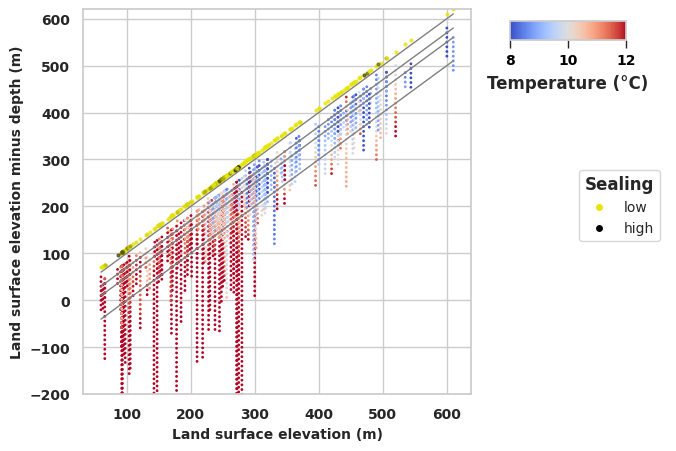

In [13]:
plot_log_distribution(df_filter, 
                      [8, 12], # T_range
                      #False
                      200, # depth
                      1 # size
                     )